In [65]:
#!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()
#hide
from fastbook import *
from fastai.vision.all import *
from fastai.vision.widgets import *
import requests


In [3]:
def search_images_bing_new(key, term, customConfigId, min_sz=128):
	url = 'https://api.bing.microsoft.com/v7.0/custom/images/search?' + 'q=' + term + '&' + 'customconfig=' + customConfigId + '&' + 'count=150'
	r = requests.get(url, headers={'Ocp-Apim-Subscription-Key': key})
	search_results = r.json()
	return L([img["thumbnailUrl"] + ".jpg" for img in search_results["value"][:150]])


In [4]:
hotdogs = search_images_bing_new('1be3ada0f2a649d087e9fb39798485a0', 'hotdog', 'efb1b149-c219-4091-be6d-14a279c405c4')

In [5]:
hotdogs

(#150) ['https://tse2.mm.bing.net/th?id=OIP.WwNG0Db_o58XuR8uyHFGJQHaE8&pid=Api.jpg','https://tse3.mm.bing.net/th?id=OIP.1Xkr3YbMeVXI-QJL8w6AigHaDt&pid=Api.jpg','https://tse2.mm.bing.net/th?id=OIP.QHEOpw8npesuG0h6ojJ0HwHaFj&pid=Api.jpg','https://tse3.mm.bing.net/th?id=OIP.UyKMCHBsnEpwRGlJmu1HWQHaE8&pid=Api.jpg','https://tse2.mm.bing.net/th?id=OIP.3IVuG7q7Q3B_BmyXkvjz0gHaFj&pid=Api.jpg','https://tse4.mm.bing.net/th?id=OIP.GNLLKkmhb5bXAwQ2z8Vh7AHaFj&pid=Api.jpg','https://tse4.mm.bing.net/th?id=OIP.uovloOsMkI8LfzTheiLThQHaE6&pid=Api.jpg','https://tse4.mm.bing.net/th?id=OIP.au202vJwBfwntBr4Byjw5wHaFj&pid=Api.jpg','https://tse1.mm.bing.net/th?id=OIP.nE5Gj2cAgzraJHOhzBG65AHaEK&pid=Api.jpg','https://tse3.mm.bing.net/th?id=OIP.WqTuusD_RbVuMEIbIDlFsQHaD4&pid=Api.jpg'...]

In [6]:
hotdogs[0]

'https://tse2.mm.bing.net/th?id=OIP.WwNG0Db_o58XuR8uyHFGJQHaE8&pid=Api.jpg'

In [7]:
food_types = 'hotdog','burger'
path = Path('foods')
if not path.exists():
  path.mkdir()
  for f in food_types:
    dest = (path/f)
    dest.mkdir(exist_ok=True)
    results = search_images_bing_new('1be3ada0f2a649d087e9fb39798485a0', f, 'efb1b149-c219-4091-be6d-14a279c405c4')
    download_images(dest, urls=results)

In [8]:
fns = get_image_files(path)
fns

(#300) [Path('foods/burger/00000077.jpg'),Path('foods/burger/00000097.jpg'),Path('foods/burger/00000061.jpg'),Path('foods/burger/00000102.jpg'),Path('foods/burger/00000107.jpg'),Path('foods/burger/00000132.jpg'),Path('foods/burger/00000096.jpg'),Path('foods/burger/00000079.jpg'),Path('foods/burger/00000110.jpg'),Path('foods/burger/00000125.jpg')...]

In [9]:
failed = verify_images(fns)
failed

(#0) []

In [10]:
class DataLoaders(GetAttr):
  def __init__(self, *loaders): self.loaders = loaders
  def __getitem__(self, i): return self.loaders[i]
  train, valid = add_props(lambda i, self: self[i])

In [11]:
foods = DataBlock(
blocks=(ImageBlock, CategoryBlock),
get_items=get_image_files,
splitter=RandomSplitter(valid_pct=0.2, seed=42),
get_y=parent_label,
item_tfms=Resize(128))

In [12]:
dls = foods.dataloaders(path)

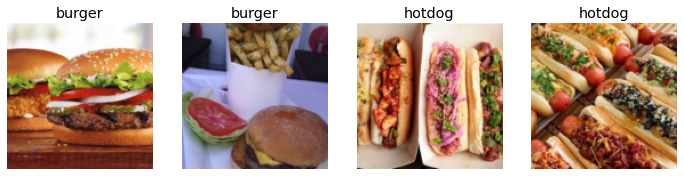

In [13]:
dls.valid.show_batch(max_n=4, nrows=1)

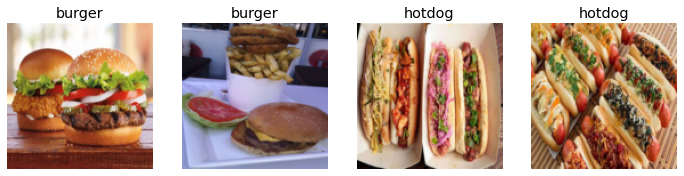

In [14]:
foods = foods.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = foods.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

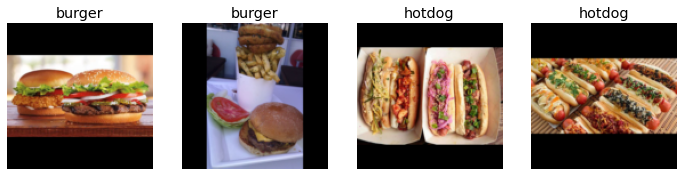

In [15]:
foods = foods.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = foods.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

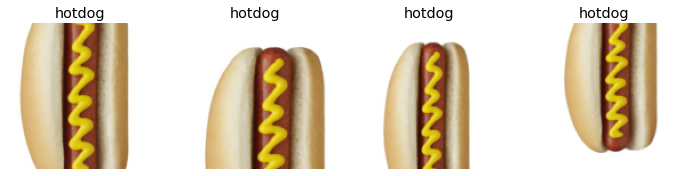

In [16]:
foods = foods.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = foods.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

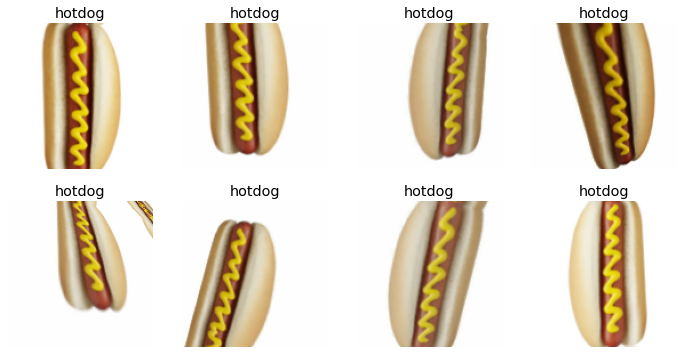

In [17]:
foods = foods.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = foods.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

In [18]:
foods = foods.new(
item_tfms=RandomResizedCrop(224, min_scale=0.5),
batch_tfms=aug_transforms())
dls = foods.dataloaders(path)

In [19]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


epoch,train_loss,valid_loss,error_rate,time
0,0.816658,0.570072,0.233333,00:44


epoch,train_loss,valid_loss,error_rate,time
0,0.328600,0.333271,0.133333,01:08
1,0.236929,0.163014,0.083333,01:01
2,0.181611,0.150076,0.066667,01:01
3,0.144509,0.194078,0.083333,01:01


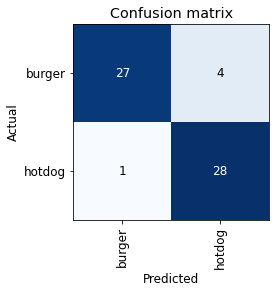

In [20]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

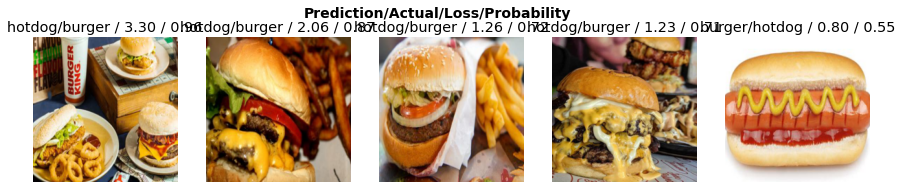

In [21]:
interp.plot_top_losses(5, nrows=1)

In [23]:
learn.export()

In [24]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [25]:
learn_inf = load_learner(path/'export.pkl')

In [26]:
learn_inf.predict('/content/Hamburger.jpg')

('burger', tensor(0), tensor([0.9987, 0.0013]))

In [27]:
learn_inf.dls.vocab

['burger', 'hotdog']

In [31]:
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [52]:
img = PILImage.create(btn_upload.data[-1])

In [53]:
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [54]:
pred,pred_idx,probs = learn_inf.predict(img)

In [55]:
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: burger; Probability: 0.9987')

In [49]:
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [63]:
def on_click_classify(change):
  img = PILImage.create(btn_upload.data[-1])
  out_pl.clear_output()
  with out_pl: display(img.to_thumb(128,128))
  pred,pred_idx,probs = learn_inf.predict(img)  
  lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
btn_run.on_click(on_click_classify)

In [66]:
VBox([widgets.Label('Select your Food!'),
btn_upload, btn_run, out_pl, lbl_pred])